# WORD PAIRS

**File:** WordPairs.ipynb

**Course:** Data Science Foundations: Data Mining in Python

# INSTALL AND IMPORT LIBRARIES

To explore the connections between words, we'll use the Python library `networkx`. It can be installed with Python's `pip` command. This command only needs to be done once per machine.

The standard, shorter approach may work:

In [18]:
pip install networkx

If the above command didn't work, it may be necessary to be more explicit, in which case you could run the code below.

In [19]:
# import sys
# !{sys.executable} -m pip install networkx

Once `networkx` is installed, then load the libraries below.

In [20]:
# Import libraries
import re  # For regular expressions
import nltk  # For text functions
import matplotlib.pyplot as plt  # For plotting
import pandas as pd  # For dataframes
import networkx as nx  # For network graphs

# Import specific text functions from NLTK
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

# Download data for NLTK
nltk.download('stopwords', quiet=True)
nltk.download('opinion_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

True

# IMPORT DATA

In [21]:
df = pd.read_csv('Iliad.txt',sep='\t')\
    .dropna() \
    .drop('gutenberg_id', 1)

df.head(10)

C:\Users\t8367j1\AppData\Local\Temp/ipykernel_16760/591572471.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.read_csv('Iliad.txt',sep='\t')\


,text
0,THE ILIAD OF HOMER
2,RENDERED INTO ENGLISH BLANK VERSE.
3,BY
5,EDWARD EARL OF DERBY.
10,PREFACE.
13,"In the spring of 1862 I was induced, at the re..."
14,"friends, to print, for private circulation onl..."
15,"""Translations of Poems Ancient and Modern,"" in..."
16,first Book of the Iliad. The opinions expresse...
17,judges of the degree of success which had atte...


# PREPARE DATA


## Tokenize the Data

In [22]:
def clean_text(text):
    text = text.lower() # lowecase
    text = text.replace("'", '')
    text = re.sub(r'[^\w]', ' ', text) # leave only word characters
    text = re.sub(r'\s+', ' ', text) # ommit extra space characters
    text = text.strip()
    return text


df['text'] = df['text'].map(clean_text) 
df['text'] = df['text'].map(word_tokenize) # Split text into words

df.head()

,text
0,"[the, iliad, of, homer]"
2,"[rendered, into, english, blank, verse]"
3,[by]
5,"[edward, earl, of, derby]"
10,[preface]


## CREATE WORD PAIR TOKENS

- Instead of splitting the text into single words, separate it into pairs of adjacent words.

In [23]:
#ngrams is a generic word, but in this example we are looking at pairs
df['wordpairs'] = df['text'].map(lambda x: list(ngrams(x, 2)))
df = df.explode('wordpairs')

df.head(10)

,text,wordpairs
0,"[the, iliad, of, homer]","(the, iliad)"
0,"[the, iliad, of, homer]","(iliad, of)"
0,"[the, iliad, of, homer]","(of, homer)"
2,"[rendered, into, english, blank, verse]","(rendered, into)"
2,"[rendered, into, english, blank, verse]","(into, english)"
2,"[rendered, into, english, blank, verse]","(english, blank)"
2,"[rendered, into, english, blank, verse]","(blank, verse)"
3,[by],NaN
5,"[edward, earl, of, derby]","(edward, earl)"
5,"[edward, earl, of, derby]","(earl, of)"


## Sort the Tokens by Frequency

In [24]:
df['wordpairs'].value_counts().head(10)

(to, the)        525
(in, the)        450
(of, the)        447
(from, the)      443
(the, greeks)    330
(on, the)        307
(son, of)        279
(all, the)       223
(and, the)       218
(the, ships)     213
Name: wordpairs, dtype: int64

## Split Word Pairs

- In order to remove word pairs with stop words, the pairs must first be separated.
- Separated pairs are also necessary for creating network graphs.

In [25]:
df = pd.DataFrame(df.wordpairs.values.tolist(), columns=['word1', 'word2']).dropna()

df.head(10)

,word1,word2
0,the,iliad
1,iliad,of
2,of,homer
3,rendered,into
4,into,english
5,english,blank
6,blank,verse
8,edward,earl
9,earl,of
10,of,derby


- Get the number of rows in the dataframe.

In [26]:
df.shape

(127709, 2)

## Remove Stop Words

- This reduces the total number of observations from 127,709 to 33,694, a 74% reduction.

In [27]:
en_stopwords = set(stopwords.words('english'))

df = df[~(df.word1.isin(en_stopwords) | df.word2.isin(en_stopwords))]

df.head()

,word1,word2
5,english,blank
6,blank,verse
8,edward,earl
29,private,circulation
33,small,volume


- Get the new number of rows in the dataframe.

In [28]:
df.shape

(33694, 2)

## Sort Word Pairs by Frequency

In [29]:
df = df.groupby(['word1', 'word2'])\
    .size()\
    .to_frame('n')\
    .reset_index()\
    .sort_values('n', ascending=False)

df.head(20)

,word1,word2,n
13491,old,man,51
14197,peleus,son,51
18855,th,immortal,44
16053,saturns,son,43
932,answerd,thus,42
1410,atreus,son,42
13173,noble,son,41
19226,thou,art,39
19687,thus,addressd,38
217,achilles,swift,38


# VISUALIZE DATA

## Create Data Table

- Restrict to word pairs that appear more than 12 times.

In [31]:
df[df.n > 12].head(10)

,word1,word2,n
13491,old,man,51
14197,peleus,son,51
18855,th,immortal,44
16053,saturns,son,43
932,answerd,thus,42
1410,atreus,son,42
13173,noble,son,41
19226,thou,art,39
19687,thus,addressd,38
217,achilles,swift,38


## Visualize Network Graph

- For clarity's sake, restrict to word pairs that appear more than 25 times.

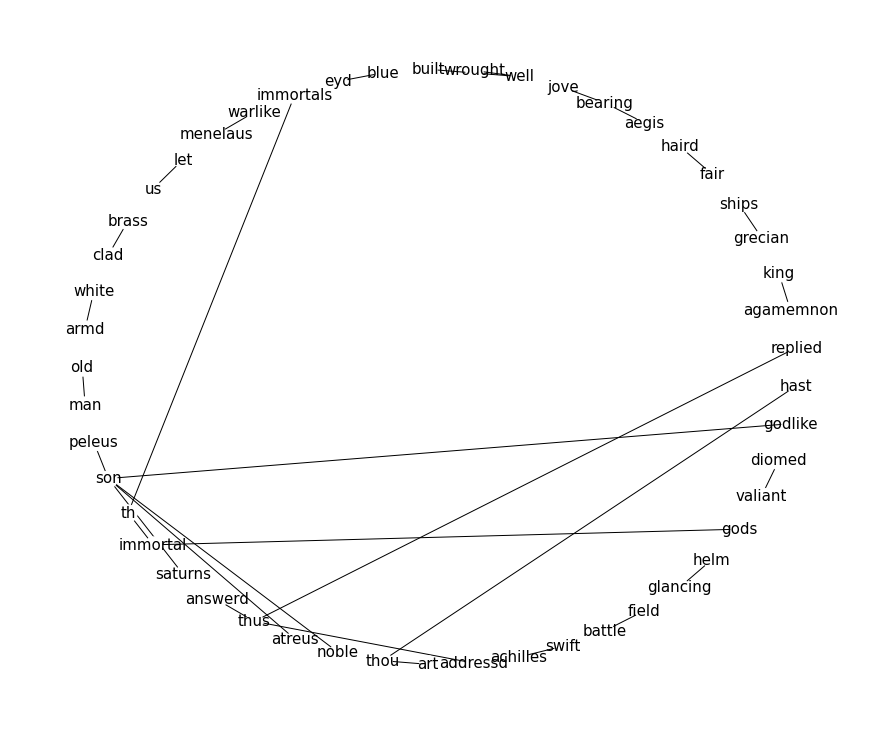

In [32]:
G = nx.from_pandas_edgelist(df[df.n > 25], 'word1', 'word2')
plt.figure(figsize=(12, 10))
nx.draw_shell(G, with_labels=True, node_color='white', font_size=15)